<a href="https://colab.research.google.com/github/LuluW8071/Data-Science/blob/main/Pytorch/09_PyTorch_GANs/01_PyTorch_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)

Before diving into GANs, we must understand "What is Adversarial Learning and Generative Models?"

## Adversarial Learning

Adversarial machine learning is a technique used in ML to fool or misguide a model with malicious (fake) input. It includes both the generation and detection of adversarial examples, which are inputs specifically created to deceive classifiers.

## Generative Models

Models that can generate new data samples from the learned data distribution is Generative Model. If we focus on images, then generative models learn the pixel intensity distribution.

</br>
<img src = "https://miro.medium.com/v2/resize:fit:1400/0*DJGVvDYO6-u-WYhk.gif">

**Generative Adversarial Networks (GANs)** are a class of machine learning models used for generating new data samples that resemble a given dataset. It is the generative and adversarial unsupervised learning algorithm. They consist of two neural networks:
- generator
- discriminator

The **generator** creates fake data, while the **discriminator** evaluates the authenticity of the data, distinguishing between real and fake samples. The two networks are trained simultaneously in a competitive process: the generator improves its ability to produce realistic data, and the discriminator enhances its skill in detecting fake data. This adversarial training process leads to the generator producing highly realistic data, making GANs powerful tools for tasks like image synthesis, video generation, and data augmentation.

### [Paper on GAN](https://arxiv.org/abs/1406.2661)
## GAN Architecture & Working Mechanism

<img src="https://www.researchgate.net/publication/381190110/figure/fig1/AS:11431281249828567@1717656324796/Illustration-of-a-Generative-Adversarial-Network-Gharakhanian.ppm">

1. **Input Noise:** The process starts with the generator receiving random noise from the latent space.

2. **Data Generation:** The generator transforms this noise into a new data sample, trying to mimic the real data distribution.

3. **Discrimination:** The generated data sample is then fed into the discriminator alongside real samples from the training set.

4. **Classification:** The discriminator evaluates the data and determines whether each sample is real or fake.

5. **Feedback Loop:** If the discriminator correctly identifies the fake sample, it means the generator needs improvement. The generator is trained to produce more realistic data to fool the discriminator in the next round. Conversely, if the discriminator is fooled by the fake data, it needs further training to improve its accuracy.

6. **Adversarial Training:** The generator and discriminator are trained simultaneously in a zero-sum game. The generator's objective is to maximize the discriminator's error rate, effectively generating more realistic data. The discriminator's objective is to minimize its error rate, improving its ability to distinguish between real and fake samples.

This adversarial process continues until the generator produces sufficiently realistic data that the discriminator can no longer distinguish it from real data with high accuracy.




## 0. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Data Preparation

Using MNIST dataset (handwritten-digits) images for data and training GAN on it to classify the real and fake samples not labels.

In [2]:
# Transform the PIL Image array
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,),(0.5,)),    # Normalizes on range -1 to 1 [output = (input - mean) / std]
])

# Setting up training data
train_data = datasets.MNIST(root="data",            # Storage location of dataset
                            train=True,             # Indication of downloading train_datasets
                            download=True,          # Flag to set for downloading datasets
                            transform=transform,    # Transformation of image dataset
                            target_transform=None)  # Flag to set for transformation of labels/targets

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17514463.66it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488700.64it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3771838.06it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1979687.08it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 2. Visualization of MNIST Data Samples

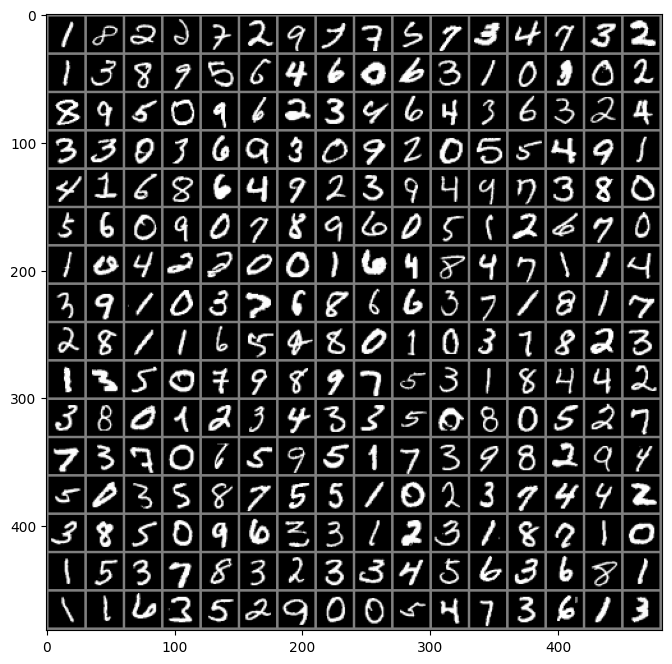

Shape of a batch of images: torch.Size([256, 1, 28, 28])


In [3]:
def visualize(img):
    img = img/2 + 0.5       # Denormalize
    img_np = img.numpy()    # Transform to numpy array
    plt.imshow(np.transpose(img_np, (1, 2, 0)), cmap='gray')
    plt.show()

def show_grid(images):
    img_grid = torchvision.utils.make_grid(images, nrow=16)
    visualize(img_grid)

# Get some random training images
trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Display the images in a grid
plt.figure(figsize=(8, 8))
show_grid(images)

print(f"Shape of a batch of images: {images.shape}")

## 3. Building GAN Neural Network
### 3.1 Building Discriminator

Discriminator is a classifier that takes image as input and distinguishes between Real or Fake as output.

>For now we will be building a discriminator using MLP (Multi-Layer Perceptron).

In [4]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.flatten = nn.Flatten()         # Flatten shapes 2D-images to 1D array
        self.classifier = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(hidden_size, hidden_size//2),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(hidden_size//2, hidden_size//4),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(hidden_size//4, output_size),
                nn.Sigmoid()                # Sigmoid activation is used in discriminator as it
                )                           # is always a Binary Classification (0-Fake or 1-Real)

    def forward(self, x):
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [5]:
discriminator = Discriminator(input_size = 28*28,           # Width * Height of input images
                              hidden_size = 1024,
                              output_size = 1).to(device)   # Binary Classification

discriminator

Discriminator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

### 3.2 Building Generator Network

Generator is a model that generates a fake image from a vector also called latent vector or noise vector.

> For now we will be building a generator using MLP as well and `latent vector of dimension 100` shall be used.

> NOTE:
- Latent vector dimension must be between image shape(width*height).
- It also must not be set too high or too low.
- It is generally beneficial to use architectures with a similar number of layers for both the generator and discriminator because maintaining a balance in their complexity can prevent one network from overpowering the other, thus ensuring more stable and effective training.

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.classifier = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(hidden_size, hidden_size//2),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(hidden_size//2, hidden_size//4),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(hidden_size//4, output_size),
                nn.Tanh()                   # Tanh activation is used in Generator as images were
                )                           # normalized to range -1 to in the beginning.

    def forward(self, x):
        x = self.classifier(x)
        x = x.reshape(x.size(0), 1, 28, 28)
        return x

In [7]:
latent_dim = 100
generator = Generator(input_size = latent_dim,          # latent vector or noise vector dimension
                      hidden_size = 1024,
                      output_size = 28*28).to(device)   # Original Image Size

generator

Generator(
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=784, bias=True)
    (10): Tanh()
  )
)

### 3.3 Objective Function for GAN

#### 3.3.1 Discriminator Objective Function

The discriminator aims to distinguish between real images (labeled 1) and fake images (labeled 0). Trained on a mix of real and generated images, it computes two key losses:
- **Real Data Loss**: Loss when correctly identifying real images.
- **Fake Data Loss**: Loss when correctly identifying generated (fake) images.

Using Binary Cross-Entropy for its binary classification task, the discriminator's total loss sums these components:
- **Total Discriminator Loss = Real Data Loss + Fake Data Loss**

**Objective**: Minimize the total discriminator loss to enhance classification accuracy.

#### 3.3.2 Generator Objective Function

The generator's goal is to produce realistic images that deceive the discriminator. Its loss increases if the discriminator correctly identifies a generated image as fake, and decreases if the image is classified as real. This adversarial setup uses Binary Cross-Entropy Loss for training.

## 4. Setup Loss function and Optimizer

In [8]:
loss_fn = nn.BCELoss()                                           # Binary Cross Entropy Loss
gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4)      # Optimizer for Generator
dis_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4)  # Optimizer for Discriminator

## 5. Train GAN
### 5.1 Steps for Training Discriminator

1. **Input Real Images**: Feed a mini-batch of real images from the training set into the discriminator.
   
2. **Calculate Real Data Loss**: Compute the discriminator's loss using the real images to measure how well it identifies them as real.
   
3. **Generate Latent Vectors**: Generate latent vectors from a normal distribution for the mini-batch of images.
   
4. **Generate Fake Images**: Use these latent vectors as input to the generator to produce fake images.
   
5. **Input Fake Images**: Feed the generated fake images into the discriminator.
   
6. **Calculate Fake Data Loss**: Compute the discriminator's loss using the fake images to evaluate its ability to distinguish them as fake.
   
7. **Compute Total Discriminator Loss**: Combine the losses from steps 2 and 6 to get the total discriminator loss.
   
8. **Update Discriminator Parameters**: Compute the gradients of the total discriminator loss and use them to update the discriminator's optimizer parameters.

### 5.2 Steps for Training Generator

1. **Generate Latent Vectors**: Generate latent vectors from a normal distribution for the mini-batch of images.
   
2. **Generate Fake Images**: Use these latent vectors as input to the generator to produce fake images.
   
3. **Input Fake Images to Discriminator**: Feed the generated fake images into the discriminator.
   
4. **Calculate Generator Loss**: Compute the generator's loss based on how the discriminator classifies the generated images.
   
5. **Update Generator Parameters**: Compute the gradients of the generator loss and use them to update the generator's optimizer parameters.

These steps outline the iterative process where the discriminator learns to distinguish between real and fake images, while the generator learns to produce images that increasingly fool the discriminator.

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/60], Step [200/235], d_loss: 0.0733, g_loss: 10.3975, D(x): 0.99, D(G(z)): 0.04
Epoch [2/60], Step [200/235], d_loss: 0.0921, g_loss: 10.2993, D(x): 0.99, D(G(z)): 0.04
Epoch [3/60], Step [200/235], d_loss: 0.2413, g_loss: 10.0196, D(x): 0.98, D(G(z)): 0.11
Epoch [4/60], Step [200/235], d_loss: 0.3217, g_loss: 11.6865, D(x): 0.98, D(G(z)): 0.13
Epoch [5/60], Step [200/235], d_loss: 0.1032, g_loss: 8.1420, D(x): 0.98, D(G(z)): 0.05
Epoch [6/60], Step [200/235], d_loss: 0.3702, g_loss: 3.0600, D(x): 0.87, D(G(z)): 0.14
Epoch [7/60], Step [200/235], d_loss: 0.2493, g_loss: 6.2776, D(x): 0.94, D(G(z)): 0.07
Epoch [8/60], Step [200/235], d_loss: 0.0730, g_loss: 4.7827, D(x): 0.99, D(G(z)): 0.04
Epoch [9/60], Step [200/235], d_loss: 0.1468, g_loss: 6.1729, D(x): 0.95, D(G(z)): 0.04
Epoch [10/60], Step [200/235], d_loss: 0.1589, g_loss: 5.8521, D(x): 0.95, D(G(z)): 0.05


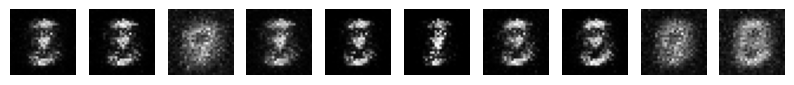

Epoch [11/60], Step [200/235], d_loss: 0.2046, g_loss: 7.6141, D(x): 0.94, D(G(z)): 0.03
Epoch [12/60], Step [200/235], d_loss: 0.1792, g_loss: 6.1392, D(x): 0.96, D(G(z)): 0.05
Epoch [13/60], Step [200/235], d_loss: 0.2011, g_loss: 5.9968, D(x): 0.93, D(G(z)): 0.03
Epoch [14/60], Step [200/235], d_loss: 0.3823, g_loss: 8.0307, D(x): 0.85, D(G(z)): 0.00
Epoch [15/60], Step [200/235], d_loss: 0.2424, g_loss: 5.9437, D(x): 0.97, D(G(z)): 0.10
Epoch [16/60], Step [200/235], d_loss: 0.1757, g_loss: 5.7509, D(x): 0.98, D(G(z)): 0.10
Epoch [17/60], Step [200/235], d_loss: 0.2278, g_loss: 5.3009, D(x): 0.97, D(G(z)): 0.09
Epoch [18/60], Step [200/235], d_loss: 0.2480, g_loss: 5.5931, D(x): 0.92, D(G(z)): 0.07
Epoch [19/60], Step [200/235], d_loss: 0.1540, g_loss: 3.7311, D(x): 0.96, D(G(z)): 0.06
Epoch [20/60], Step [200/235], d_loss: 0.3434, g_loss: 5.0231, D(x): 0.97, D(G(z)): 0.18


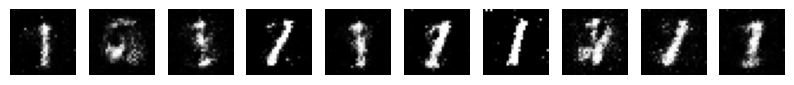

Epoch [21/60], Step [200/235], d_loss: 0.2633, g_loss: 3.6142, D(x): 0.95, D(G(z)): 0.12
Epoch [22/60], Step [200/235], d_loss: 0.2293, g_loss: 4.3907, D(x): 0.93, D(G(z)): 0.08
Epoch [23/60], Step [200/235], d_loss: 0.3131, g_loss: 4.2629, D(x): 0.91, D(G(z)): 0.10
Epoch [24/60], Step [200/235], d_loss: 0.3325, g_loss: 4.4637, D(x): 0.89, D(G(z)): 0.08
Epoch [25/60], Step [200/235], d_loss: 0.2878, g_loss: 3.5458, D(x): 0.91, D(G(z)): 0.07
Epoch [26/60], Step [200/235], d_loss: 0.3195, g_loss: 3.8985, D(x): 0.89, D(G(z)): 0.05
Epoch [27/60], Step [200/235], d_loss: 0.3814, g_loss: 2.2669, D(x): 0.92, D(G(z)): 0.17
Epoch [28/60], Step [200/235], d_loss: 0.3698, g_loss: 2.7124, D(x): 0.88, D(G(z)): 0.10
Epoch [29/60], Step [200/235], d_loss: 0.3596, g_loss: 3.4801, D(x): 0.89, D(G(z)): 0.10
Epoch [30/60], Step [200/235], d_loss: 0.4157, g_loss: 2.8831, D(x): 0.84, D(G(z)): 0.09


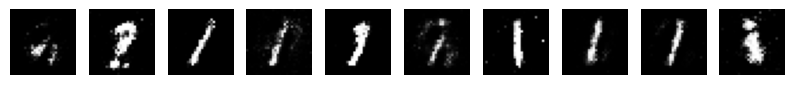

Epoch [31/60], Step [200/235], d_loss: 0.4256, g_loss: 2.7527, D(x): 0.86, D(G(z)): 0.13
Epoch [32/60], Step [200/235], d_loss: 0.3620, g_loss: 3.8737, D(x): 0.87, D(G(z)): 0.08
Epoch [33/60], Step [200/235], d_loss: 0.4038, g_loss: 3.1901, D(x): 0.88, D(G(z)): 0.12
Epoch [34/60], Step [200/235], d_loss: 0.5325, g_loss: 2.5129, D(x): 0.82, D(G(z)): 0.12
Epoch [35/60], Step [200/235], d_loss: 0.4786, g_loss: 2.7744, D(x): 0.83, D(G(z)): 0.14
Epoch [36/60], Step [200/235], d_loss: 0.5180, g_loss: 3.4020, D(x): 0.90, D(G(z)): 0.20
Epoch [37/60], Step [200/235], d_loss: 0.6385, g_loss: 1.9205, D(x): 0.82, D(G(z)): 0.21
Epoch [38/60], Step [200/235], d_loss: 0.5580, g_loss: 2.6707, D(x): 0.82, D(G(z)): 0.18
Epoch [39/60], Step [200/235], d_loss: 0.5244, g_loss: 2.2693, D(x): 0.88, D(G(z)): 0.23
Epoch [40/60], Step [200/235], d_loss: 0.6325, g_loss: 2.0624, D(x): 0.83, D(G(z)): 0.21


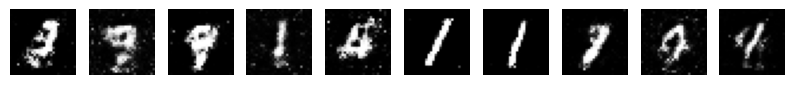

Epoch [41/60], Step [200/235], d_loss: 0.4533, g_loss: 3.0059, D(x): 0.82, D(G(z)): 0.11
Epoch [42/60], Step [200/235], d_loss: 0.5173, g_loss: 2.0480, D(x): 0.88, D(G(z)): 0.20
Epoch [43/60], Step [200/235], d_loss: 0.6765, g_loss: 2.1771, D(x): 0.77, D(G(z)): 0.15
Epoch [44/60], Step [200/235], d_loss: 0.5060, g_loss: 2.9071, D(x): 0.85, D(G(z)): 0.17
Epoch [45/60], Step [200/235], d_loss: 0.5957, g_loss: 2.4969, D(x): 0.80, D(G(z)): 0.17
Epoch [46/60], Step [200/235], d_loss: 0.6952, g_loss: 2.0113, D(x): 0.76, D(G(z)): 0.19
Epoch [47/60], Step [200/235], d_loss: 0.6314, g_loss: 2.1423, D(x): 0.83, D(G(z)): 0.22
Epoch [48/60], Step [200/235], d_loss: 0.5893, g_loss: 1.8423, D(x): 0.84, D(G(z)): 0.22
Epoch [49/60], Step [200/235], d_loss: 0.7194, g_loss: 1.7747, D(x): 0.80, D(G(z)): 0.26
Epoch [50/60], Step [200/235], d_loss: 0.7476, g_loss: 2.4529, D(x): 0.80, D(G(z)): 0.27


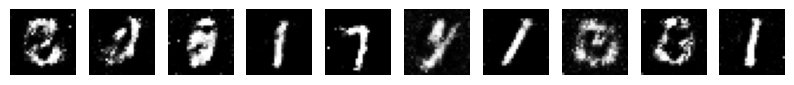

Epoch [51/60], Step [200/235], d_loss: 0.7341, g_loss: 1.8847, D(x): 0.76, D(G(z)): 0.21
Epoch [52/60], Step [200/235], d_loss: 0.6963, g_loss: 1.8248, D(x): 0.75, D(G(z)): 0.20
Epoch [53/60], Step [200/235], d_loss: 0.5348, g_loss: 2.7146, D(x): 0.81, D(G(z)): 0.16
Epoch [54/60], Step [200/235], d_loss: 0.6505, g_loss: 1.8802, D(x): 0.78, D(G(z)): 0.20
Epoch [55/60], Step [200/235], d_loss: 0.8034, g_loss: 1.9737, D(x): 0.77, D(G(z)): 0.28
Epoch [56/60], Step [200/235], d_loss: 0.7260, g_loss: 1.9317, D(x): 0.84, D(G(z)): 0.31
Epoch [57/60], Step [200/235], d_loss: 0.7782, g_loss: 2.2929, D(x): 0.77, D(G(z)): 0.26
Epoch [58/60], Step [200/235], d_loss: 0.7558, g_loss: 1.9950, D(x): 0.79, D(G(z)): 0.28
Epoch [59/60], Step [200/235], d_loss: 0.7703, g_loss: 1.9965, D(x): 0.80, D(G(z)): 0.30
Epoch [60/60], Step [200/235], d_loss: 0.8129, g_loss: 1.9484, D(x): 0.67, D(G(z)): 0.17


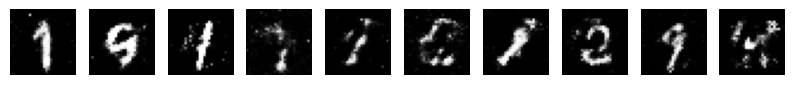

In [10]:
num_epochs = 60
discriminator_loss, generator_loss = [], []     # List to accumulate discriminator and generator loss

# Train loop
for epoch in tqdm(range(num_epochs)):
    dis_epoch_loss, gen_epoch_loss = 0, 0

    for i, (images, _) in enumerate(trainloader):
        # Create labels for training discriminator and generator
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        images = images.to(device)

        # Training Discriminator
        outputs = discriminator(images)                         # Infer the discriminator on real images
        dis_real_data_loss = loss_fn(outputs, real_labels)      # Calculate the loss with real labels
        real_score = outputs
        noise = torch.randn(batch_size, latent_dim).to(device)  # Generate random latent vectors from normal distribution
        fake_images = generator(noise)                          # Generate fake images by passing latent vector to generator
        outputs = discriminator(fake_images)                    # Infer the discriminator on fake images
        dis_fake_data_loss = loss_fn(outputs, fake_labels)      # Calculate the loss with fake labels
        fake_score = outputs
        dis_loss = dis_real_data_loss + dis_fake_data_loss      # Calculate the total loss
        dis_epoch_loss += dis_loss.item()

        # Update the weights
        dis_optimizer.zero_grad()
        dis_loss.backward()
        dis_optimizer.step()

        # Training Generator
        noise = torch.randn(batch_size, latent_dim).to(device)  # Generate random latent vectors from normal distribution
        fake_images = generator(noise)                          # Generate fake images by passing latent vector to generator
        outputs = discriminator(fake_images)                    # Infer the discriminator on fake images
        gen_loss = loss_fn(outputs, real_labels)                # Calculate the loss with real labels
        gen_epoch_loss += gen_loss.item()

        # Update the weights
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {dis_loss.item():.4f}, g_loss: {gen_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(noise)): {fake_score.mean().item():.2f}')

    generator_loss.append(gen_epoch_loss/i)
    discriminator_loss.append(dis_epoch_loss/i)

    # Visualize the intermediate results
    if (epoch+1) % 10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        fake_images = fake_images.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].imshow(fake_images[i, 0], cmap='gray')
            ax[i].axis('off')
        plt.show()

## 6. Plot Loss Curves

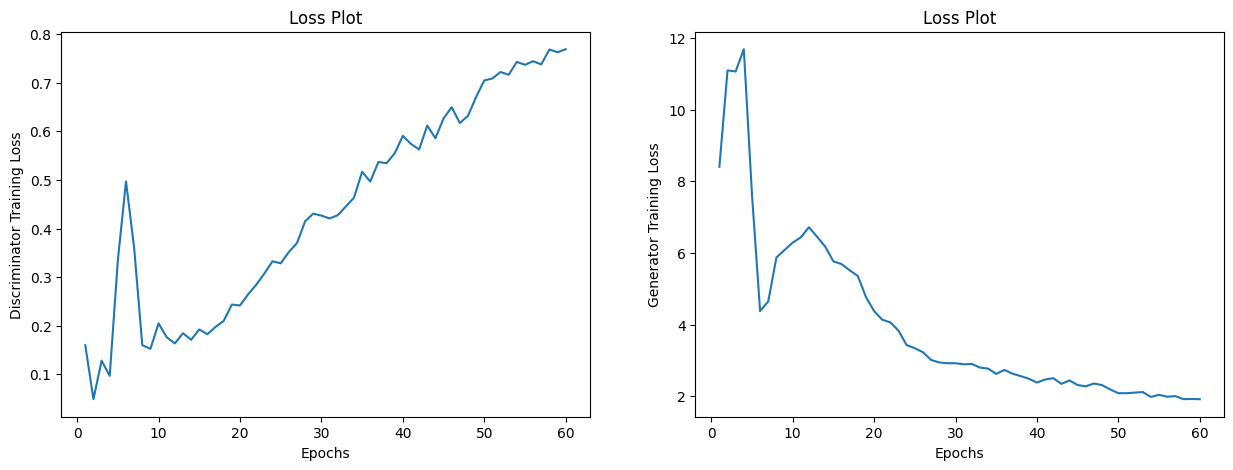

In [26]:
plt.figure(figsize=(15, 5))

# Subplot for discriminator and generator loss
plt.subplot(1, 2, 1)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, discriminator_loss)
plt.xlabel("Epochs")
plt.ylabel("Discriminator Training Loss")

plt.subplot(1, 2, 2)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

## 7. Saving Models

In [13]:
from pathlib import Path

# Create model directory
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

# Create model save path
GEN_MODEL_NAME, DIS_MODEL_NAME = "generator.pt", "discriminator.pt"
gen_model_save_path = model_path / GEN_MODEL_NAME
dis_model_save_path = model_path / DIS_MODEL_NAME

# Save the model state dict
print(f"Saving model to: {gen_model_save_path}")
print(f"Saving model to: {dis_model_save_path}")
torch.save(obj = generator.state_dict(),        # only saving the state_dict() only saves the learned parameters
           f = gen_model_save_path)
torch.save(obj = discriminator.state_dict(),        # only saving the state_dict() only saves the learned parameters
           f = dis_model_save_path)
print('Saved Successfully')

Saving model to: models/generator.pt
Saving model to: models/discriminator.pt
Saved Successfully


## 8. Generate Image by Inferencing on Trained GAN

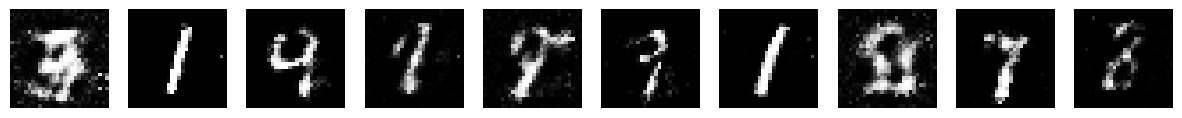

In [25]:
# Generator model
generator = Generator(input_size = 100,
                      hidden_size = 1024,
                      output_size = 28*28)

#  Load the model to cpu and set tot eval mode
generator.load_state_dict(torch.load(f=gen_model_save_path, map_location='cpu'))
generator.eval()

# Generate latent vectors
num_samples = 10
input_noise = torch.randn(num_samples, latent_dim).to('cpu')

# Generate image using latent vectors
generated_samples = generator(input_noise)
generated_samples_np = generated_samples.detach().cpu().numpy()

# Visualize the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples_np[i, 0], cmap='gray')
    axes[i].axis('off')
plt.show()

## 9. Other GANs

Certainly! Here's a brief overview of each type of GAN:

1. **DCGANs (Deep Convolutional GANs)**:
   - Utilize convolutional layers in both the generator and discriminator.
   - Known for stable training and generating high-quality images.

2. **Conditional GANs (cGANs)**:
   - Conditioned on additional information (labels, images, etc.) to control the image generation process.
   - Enables specific image synthesis based on given conditions.

3. **Wasserstein GANs (WGANs)**:
   - Introduce Wasserstein distance metric for better training stability.
   - Encourage smoother gradients and address mode collapse issues.

4. **Progressive GANs**:
   - Trained in stages starting from lower-resolution images to high-resolution ones.
   - Gradually increase both generator and discriminator complexity.

5. **StyleGANs (Style-Generative Adversarial Networks)**:
   - Introduce style-based architecture for better control over image synthesis.
   - Allows disentanglement of high-level attributes from detailed features.

6. **CycleGANs**:
   - Focus on learning mappings between two different domains without paired data.
   - Achieve image-to-image translation tasks, e.g., transforming horses to zebras.

7. **StarGANs (Star Generative Adversarial Networks)**:
   - Extend conditional GANs to handle multiple domains with a single model.
   - Enable image translation across multiple domains simultaneously.

These GAN variants each introduce specific innovations to address different challenges in image generation, translation, stability, and control over the output.

## Resources:

- [Video Explanation on GAN](https://www.youtube.com/watch?v=TpMIssRdhco)
- [Paper on GAN](https://arxiv.org/abs/1406.2661)
- [PyTorch Tutorial on GAN](https://www.youtube.com/watch?v=OljTVUVzPpM)